In [10]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [11]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [12]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

import hdbscan
import sklearn

In [13]:
from scipy.cluster.hierarchy import leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import to_hex
from sklearn.utils import shuffle

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'norman_GSE133344_filtered_cell_identities.csv')

#'guide_identity'

In [16]:
meta.head()

,cell_barcode,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells
0,TTGAACGAGACTCGGA-2,ARID1A_NegCtrl0__ARID1A_NegCtrl0,28684,1809,15.856274,2,True,1
1,CGTTGGGGTGTTTGTG-7,BCORL1_NegCtrl0__BCORL1_NegCtrl0,18367,896,20.498884,7,True,1
2,GAACCTAAGTGTTAGA-6,FOSB_NegCtrl0__FOSB_NegCtrl0,16296,664,24.542169,6,True,1
3,CCTTCCCTCCGTCATC-4,SET_KLF1__SET_KLF1,16262,850,19.131765,4,True,1
4,TCAATCTGTCTTTCAT-2,OSR2_NegCtrl0__OSR2_NegCtrl0,16057,1067,15.048735,2,True,2


In [17]:
ids = list(meta['guide_identity'].value_counts().index)
counts = list(meta['guide_identity'].value_counts())

saveCounts = pd.DataFrame()
saveCounts['guide_identity'] = ids
saveCounts['cells'] = counts

In [18]:
filt_ids = list(saveCounts['guide_identity'][saveCounts['cells'] >  50])
len(filt_ids)

290

In [19]:
dataset_meta = ['allcrispr']
print('dataset_meta: ', dataset_meta)
print()

subcluster_names = [[i] for i in filt_ids]

sub_names_only = ['_'.join(n) for n in subcluster_names]

cluster_names = []
dataset_names = ['norman_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['allcrispr']

dataset_names:  ['norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0', 'norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0', 'norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1', 'norman_allcrispr_KLF1_NegCtrl0__KLF1_NegCtrl0', 'norman_allcrispr_TBX3_TBX2__TBX3_TBX2', 'norman_allcrispr_SLC4A1_NegCtrl0__SLC4A1_NegCtrl0', 'norman_allcrispr_ETS2_CNN1__ETS2_CNN1', 'norman_allcrispr_UBASH3B_OSR2__UBASH3B_OSR2', 'norman_allcrispr_DUSP9_ETS2__DUSP9_ETS2', 'norman_allcrispr_NegCtrl0_BAK1__NegCtrl0_BAK1', 'norman_allcrispr_NegCtrl0_KLF1__NegCtrl0_KLF1', 'norman_allcrispr_NegCtrl0_ETS2__NegCtrl0_ETS2', 'norman_allcrispr_DUSP9_NegCtrl0__DUSP9_NegCtrl0', 'norman_allcrispr_BAK1_NegCtrl0__BAK1_NegCtrl0', 'norman_allcrispr_SET_KLF1__SET_KLF1', 'norman_allcrispr_NegCtrl0_CEBPE__NegCtrl0_CEBPE', 'norman_allcrispr_CBL_NegCtrl0__CBL_NegCtrl0', 'norman_allcri

## **Cell Preprocessing**

In [ ]:
cf = []
thr_lb = [1e4]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = meta['cell_barcode'].sum()
        annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta[(meta['guide_identity'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_all_norman.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [21]:
#Conditions with too few cells after filtering
ok = []
okinds = []
for i in range(len(subcluster_names)):
    x = cf[i]
    if x.sum() > 50:
        ok += [subcluster_names[i]]
        okinds += [i]
print(len(ok))

277


In [22]:
#re-filter
dataset_meta = ['allcrispr']
print('dataset_meta: ', dataset_meta)
print()

subcluster_names = [i for i in ok]

sub_names_only = ['_'.join(n) for n in subcluster_names]

cluster_names = []
dataset_names = ['norman_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/norman_crispr/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

cf = np.array(cf)[okinds]

dataset_meta:  ['allcrispr']

dataset_names:  ['norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0', 'norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0', 'norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0', 'norman_allcrispr_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1', 'norman_allcrispr_KLF1_NegCtrl0__KLF1_NegCtrl0', 'norman_allcrispr_TBX3_TBX2__TBX3_TBX2', 'norman_allcrispr_SLC4A1_NegCtrl0__SLC4A1_NegCtrl0', 'norman_allcrispr_ETS2_CNN1__ETS2_CNN1', 'norman_allcrispr_UBASH3B_OSR2__UBASH3B_OSR2', 'norman_allcrispr_DUSP9_ETS2__DUSP9_ETS2', 'norman_allcrispr_NegCtrl0_BAK1__NegCtrl0_BAK1', 'norman_allcrispr_NegCtrl0_KLF1__NegCtrl0_KLF1', 'norman_allcrispr_NegCtrl0_ETS2__NegCtrl0_ETS2', 'norman_allcrispr_DUSP9_NegCtrl0__DUSP9_NegCtrl0', 'norman_allcrispr_BAK1_NegCtrl0__BAK1_NegCtrl0', 'norman_allcrispr_SET_KLF1__SET_KLF1', 'norman_allcrispr_NegCtrl0_CEBPE__NegCtrl0_CEBPE', 'norman_allcrispr_CBL_NegCtrl0__CBL_NegCtrl0', 'norman_allcri

In [23]:
cf = list(cf)

## **Gene Filtering**

In [24]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [25]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


In [ ]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='norman_crispr_all',batch_id=1,\
                                             n_genes=3000,exp_filter_threshold=None,cf=cf)

In [26]:
dir_string = './fits/gg_230831_025_norman_crispr_all_1' #gg_230215_025_norman_crispr_all_1
dataset_strings = [dir_string+'/'+i for i in dataset_names]

In [27]:
print(dataset_strings[0])
print(len(dataset_strings))

./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0
277


In [ ]:
# For RBPs select genes with changes in relevant parameter:

# splicing factors:
# ['SNRP70','HRNPLL','MBNL2','MBNL1','SF3B1','U2AF','SRSF2']

# terminal erythropoiesis
# other: ['RBM38','HNRNPA1']
# target: ['EBP41','EBP41']

# AUF1 paper
# degradation reps:['AUF1',]
# targets:['TNF','IL8','IL10','PLEK2','BCL2']

# Regulation 2001
# ['MYC'] degraded in K562 cells --> megakaryoblasts


# RBPS in erythropoiesis https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6066521/ + original paper:
# diff markers: ['GATA1','KLF1','SLC25A37','CD235a','GYPA',
# 'IGBP1','eIF4E','ATF4','PPR15a','GADD34']

# deg: ['PABPC1','PABPC4','CPEB4','ZFP36','ZFP36L1','ZFP36L2','ELAV1','CSDE1']
# targets: ['HBA1','KIT','eIF3','STAT5B','PABPC1']


# Deg genes elife paper:
# elife-49708-supp1-v2.xlsx, DDX6 knockout results
# deg: ['DDX6','DCP1','DCP2','PAT1B','XRN1','SMG6','YTHDF2','ATXN2']
# #possible list of target cited https://elifesciences.org/articles/49708#content 


# Add genes from perturb-sci-kinetics:

# trans_init_syn_chrom = ['GTF2E1', 'TAF2', 'MED21','MNAT1','POLR2B','POLR2K','SMC3',
# 'RAD21','CTCF','ARID1A' ]
# splic_proc = ['NCBP1','LSM2', 'LSM4', 'PRPF38B', 'HNRNPK','CPSF2', 'CPSF6', 'NUDT21', 'CSTF3']
# oxphos = ['GAPDH', 'NDUFS2', 'ACO2']
# trans_silence = ['GAPDH, NDUFS2, 191 ACO2']
# deg_process = ['UPF1', 'UPF2', 'SMG5', 'SMG7','EXOSC2', 'EXOSC5', 'EXOSC6',
# 'CSTF3', 'CPSF2', 'CPSF6', 'NUDT21', 'XRN2','RNMT', 'NCBP1' ]
# --------

#'ARRDC3' downregulates 'ITGB4'
#SNAI1 repressed CDH1 (Cadherin),NANOG, NR5A2, KIT -> https://stemcellsjournals.onlinelibrary.wiley.com/doi/full/10.1002/stem.1898
# Apoptosis--> global mRNA decay ,
#CBL targets -->EGFR, FLT3, KIT, MPL https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4775400/
#ubash3b (also + CBL) targets --> 
#ETS/FEV trans factors
#KMT2A methylation 
#MIDN degrades FOSB, EGR1, NR4A1, IRF4, NEUROD1, PAX8, GATA1 https://www.science.org/doi/10.1126/science.adh5021
#RUNX1T1 --> PTK2B, RBFOX2 alt splicing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7822815/

In [34]:
first = [i.split('_')[0] for i in ids]
secnd = [i.split('_')[1] for i in ids]

all_targets = np.unique(first+secnd)

In [35]:
new_genes = ['ITGB4','CDH1','NANOG', 'NR5A2', 'KIT', 'EGFR', 'FLT3', 'MPL',
            'FOSB', 'EGR1', 'NR4A1', 'IRF4', 'NEUROD1', 'PAX8', 'GATA1','PTK2B', 'RBFOX2']

In [36]:
ds = lp.connect(loom_filepaths[0])
g_names = ds.ra['gene_name']
ds.close()


In [37]:
#Filter out genes not in original data
markers = [i for i in new_genes if i in g_names]
markers = np.unique(markers+list(all_targets))

#Filter for genes in transcriptome reference + without duplicate references
annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header=None)

filt_markers = [m for m in markers if m in list(annots[0])]
len(filt_markers)

116

In [38]:
#Add genes to genes.csv file created by Monod (for inference)
to_change = pd.read_csv('./fits/gg_230831_025_norman_crispr_all_1/genes.csv',header=None)
first_sel = list(to_change.iloc[0])

In [39]:
uniq = [i for i in filt_markers if i not in first_sel]
first_sel = first_sel+uniq

In [49]:
#Save to original genes.csv
new_pd = pd.DataFrame(columns=range(len(first_sel)))
new_pd.loc[0] = first_sel
new_pd.to_csv('./fits/gg_230831_025_norman_crispr_all_1/genes.csv',header=None,index=None)

In [54]:
# # Test reading file in to see if it worked
# test = pd.read_csv('./fits/gg_230831_025_norman_crispr_all_1/genes.csv',header=None)

## **Inference**

In [56]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


In [ ]:
result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':10,'init_pattern':'moments','num_restarts':5})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [64]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings]
print(result_strings[0])

./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0/Bursty_Poisson_1x1/grid_scan_results.res


## **QC and Analysis of Results**

In [65]:
# a e s t h e t i c s
from matplotlib.colors import ListedColormap

#all
col_gold = [203/255,197/255,149/255]
col_gray = [116/255,112/255,113/255]
col_red = [212/255,107/255,75/255]
col_b = ['#1B9AAA']
col_beta = ['#9fcbee']
col_gamma =['#3C50B1']
col_expr = ['#9299A0']

### SI figures
ms = 0.7
lw = ms
ms_fail = 1
alf = 0.3
alf_fail = 0.5
sifig_aesth = (ms,lw,ms_fail,alf,alf_fail)

### Body figures
ms = 2
lw = ms
ms_fail = 2
alf = 0.3
alf_fail = 0.8
msfig_aesth = (ms,lw,ms_fail,alf,alf_fail)

markerstyle = None

c_highlight = col_red
c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=20
cmap = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

In [66]:
n_datasets

277

In [ ]:
#Read back in data
sr_arr = [monod.analysis.load_search_results(r) for r in result_strings] 

In [ ]:
#--- Reject genes from goodness of fit testing and  calculate std error -----
for i in range(len(sr_arr)):
    sr = sr_arr[i]
    sr.set_sampling_optimum(sr.sp.sampl_vals.index((-7.157894736842105, -1.525)))  
    
    sd = monod.analysis.load_search_data(dataset_strings[i]+'/raw.sd')
    _=sr.chisquare_testing(sd,reject_at_bounds=True) #EPS=1e-20
    sr.compute_sigma(sd,num_cores=30)
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()

INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 64 genes out of 3084. Runtime: 20.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 124 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 542 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 677 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1043 gives negative 

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 71 genes out of 3084. Runtime: 19.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 36 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 601 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 643 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 775 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 1096 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1137 gives negative s

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 134.8 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 70 genes out of 3084. Runtime: 19.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 321 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 343 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 629 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 915 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 1078 gives negative stdev; replaced with

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3028 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3037 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3039 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3041 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3043 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3044 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3047 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3072 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3073 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_CEBPE_RUNX1T1__CEBPE_RUNX1T1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 124 genes out of 3084. Runtime: 19.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 41 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 43 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 164 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 278 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 483 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 539 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 578 gives negative stdev; repla

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_KLF1_NegCtrl0__KLF1_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 118 genes out of 3084. Runtime: 21.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 43 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 64 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 74 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 78 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 241 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 348 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 473 gives negative stdev; replace

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 118 genes out of 3084. Runtime: 20.0 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 34 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 323 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 391 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 467 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 576 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 601 ran into singularity; replaced wi

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2946 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3010 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3013 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3038 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3039 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3046 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3054 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2823 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2948 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3068 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 118.6 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ETS2_CNN1__ETS2_CNN1/raw.sd.
INFO:root:Chi-square computation complete. Rejected 128 genes out of 3084. Runtime: 18.8 seconds.
INFO:root:C

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 95.1 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_UBASH3B_OSR2__UBASH3B_OSR2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 139 genes out of 3084. Runtime: 22.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 127 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 202 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 223 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 277 gives negative stdev; replaced with mean. (Searc

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2869 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3030 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3072 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 101.1 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_DUSP9_ETS2__DUSP9_ETS2/raw.sd.
INFO:ro

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2385 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2424 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2547 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2627 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2701 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2728 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2794 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2830 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2476 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2568 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2609 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2670 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2729 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2778 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2826 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_ETS2__NegCtrl0_ETS2/raw.sd.
INFO:root:Chi-square computation complete. Rejected 169 genes out of 3084. Runtime: 21.5 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 48 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 67 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 144 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 159 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 190 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 277 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 285 gives negative stdev; repla

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_DUSP9_NegCtrl0__DUSP9_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 187 genes out of 3084. Runtime: 9.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 10 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 145 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 185 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 263 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 299 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 535 gives negative stdev; rep

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3020 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3022 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3024 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3033 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3035 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3036 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3076 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3080 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2541 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2543 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2583 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2732 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2771 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2805 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2848 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2929 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2963 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3002 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_CEBPE__NegCtrl0_CEBPE/raw.sd.
INFO:root:Chi-square computation complete. Rejected 178 genes out of 3084. Runtime: 17.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 3 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 107 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 242 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 467 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 471 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 532 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 576 ran into singularity; rep

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2245 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2408 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2466 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2497 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2500 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2535 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2565 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2591 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2609 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

INFO:root:Gene 2175 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2455 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2506 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2569 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2595 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2632 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2664 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2671 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2743 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2764 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2823 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2863 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2589 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2631 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2640 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2701 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2708 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2847 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3010 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3012 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3026 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3045 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_ZNF318_NegCtrl0__ZNF318_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 142 genes out of 3084. Runtime: 10.7 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 123 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 156 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 202 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 212 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 264 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 305 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 345 gives negative stdev;

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2756 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 2785 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2839 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 2872 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3005 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3047 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3068 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 101.8 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_LHX1_ELMSAN1__LHX1_ELMSAN1/raw.sd.
INF

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_FOSB_NegCtrl0__FOSB_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 163 genes out of 3084. Runtime: 10.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 31 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 187 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 257 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 260 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 287 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 391 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 576 ran into singularity; repl

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Standard error of the MLE computation complete. Runtime: 99.8 seconds.
INFO:root:Directory ./fits/gg_230831_025_norman_crispr_all_1/analysis_figures already exists.
INFO:root:Search data loaded from ./fits/gg_230831_025_norman_crispr_all_1/norman_allcrispr_MAML2_NegCtrl0__MAML2_NegCtrl0/raw.sd.
INFO:root:Chi-square computation complete. Rejected 174 genes out of 3084. Runtime: 19.6 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.


In [ ]:
#Read back in data
sr_arr = [monod.analysis.load_search_results(r[:-4]+'_upd.res') for r in result_strings]

In [47]:
#Get all params for all conditions and genes
n_genes = sr_arr[0].n_genes
n_phys_pars = sr_arr[0].sp.n_phys_pars
par_vals_uncorrected = np.zeros((n_datasets,n_genes,n_phys_pars))

#filt = ~sr_arr[0].rejected_genes
par_vals_uncorrected[0,:,:] = sr_arr[0].phys_optimum

for j in range(1,n_datasets):
    par_vals_uncorrected[j,:,:] = sr_arr[j].phys_optimum
    #filt = filt & ~sr_arr[j].rejected_genes

In [48]:
#Read in and save raw counts
sd_arr = []
for i in range(len(sr_arr)): #inds_neg:
    sd_arr += [monod.analysis.load_search_data(dataset_strings[i]+'/raw.sd')]


INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_DLX2__NegCtrl0_DLX2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_IGDCC3_MAPK1__IGDCC3_MAPK1/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_TGFBR2_ETS2__TGFBR2_ETS2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_COL1A1_NegCtrl0__COL1A1_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_LYL1_CEBPB__LYL1_CEBPB/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_SGK1_TBX2__SGK1_TBX2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_SAMD1_PTPN12__SAMD1_PTPN12/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_ZC3HAV1_HOXC13__ZC3HAV1

INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_ELMSAN1__NegCtrl0_ELMSAN1/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_HOXC13_NegCtrl0__HOXC13_NegCtrl0_2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_HOXB9__NegCtrl0_HOXB9/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_TMSB4X_NegCtrl0__TMSB4X_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_FOSB_UBASH3B__FOSB_UBASH3B/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_CDKN1A__NegCtrl0_CDKN1A/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_TBX3_TBX2__TBX3_TBX2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_all

INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_SLC6A9_NegCtrl0__SLC6A9_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_MAPK1_PRTG__MAPK1_PRTG/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_FOSB_NegCtrl0__FOSB_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_FEV_MAP7D1__FEV_MAP7D1/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_FEV__NegCtrl0_FEV/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_UBASH3B_UBASH3A__UBASH3B_UBASH3A/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_TP73_NegCtrl0__TP73_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_FOXA3_FOXL2

INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_SET_NegCtrl0__SET_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_HOXB9_NegCtrl0__HOXB9_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_CEBPA__NegCtrl0_CEBPA/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_ZBTB25_NegCtrl0__ZBTB25_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_SGK1_S1PR2__SGK1_S1PR2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_NegCtrl0_TBX3__NegCtrl0_TBX3/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_IKZF3_NegCtrl0__IKZF3_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_PTP

INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_UBASH3B_PTPN12__UBASH3B_PTPN12/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_FOXA3_HOXB9__FOXA3_HOXB9/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_CELF2_NegCtrl0__CELF2_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_TGFBR2_IGDCC3__TGFBR2_IGDCC3_2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_COL2A1_NegCtrl0__COL2A1_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_ZNF318_FOXL2__ZNF318_FOXL2/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_CNN1_NegCtrl0__CNN1_NegCtrl0/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230215_025_norman_crispr_all_1/norman_allcrispr_S

In [49]:
#Save Spliced means
s_means = np.zeros((n_datasets,n_genes))

for j in range(0,n_datasets):
    s_means[j,:] = np.mean(sd_arr[j].layers[1,:,:],axis=1)

**Validation of Activated Genes**

In [74]:
#Find ctrls in list
search = ['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0','NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0',
          'NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']

control_filt = [((search[0] in i) or (search[1] in i) or (search[2] in i)) for i in dataset_strings  ]




In [75]:
np.sum(control_filt)

3

In [153]:
#Break up result_strings by _, get genes (first two)
actGenes = [i.split('_')[8:10] for i in dataset_strings]
#Remove genes with two 'Neg' in them or no 'Neg' + np.unique
uniq = np.unique(actGenes)
uniq = [i for i in uniq if 'Neg' not in i]


fcs = []
param_nm = []
cond_nm = []
means = []
#For each gene
ctrls = par_vals_uncorrected[control_filt,:,:]
gene_names = sr_arr[0].gene_names

for u in uniq:
    g_filt = gene_names == u
#For each result
    for i in range(len(dataset_strings)):
    #If gene and 'Neg' in it, add b,beta,gamma FC with each control
        nm = dataset_strings[i]
        if (u in nm) and ('Neg' in nm) and (np.sum(g_filt != 0)):

            c = ctrls[:,g_filt,:]
            perturb = par_vals_uncorrected[i,g_filt,:]
            
            fcs += [perturb[0,0] - c[0,0,0],perturb[0,0] - c[1,0,0],perturb[0,0] - c[2,0,0],
                    perturb[0,1] - c[0,0,1],perturb[0,1] - c[1,0,1],perturb[0,1] - c[2,0,1],
                   perturb[0,2] - c[0,0,2],perturb[0,2] - c[1,0,2],perturb[0,2] - c[2,0,2]]
            param_nm += ['b']*3+['beta']*3+['gamma']*3
            cond_nm += [u]*9
            means += [s_means[i,g_filt][0]]*9
 
          
fc_res = pd.DataFrame()
fc_res['FC'] = list(np.log2(10**(np.array(fcs))))
fc_res['Param'] = param_nm
fc_res['sgRNA'] = cond_nm
fc_res['meanS'] = means
            
  
            
    

In [154]:
fc_res.head()

,FC,Param,sgRNA,meanS
0,0.671309,b,ARID1A,1.341317
1,1.084044,b,ARID1A,1.341317
2,0.630654,b,ARID1A,1.341317
3,0.510043,beta,ARID1A,1.341317
4,0.861533,beta,ARID1A,1.341317


In [155]:
len(np.unique(fc_res['sgRNA']))

29

<AxesSubplot:xlabel='Param', ylabel='FC'>

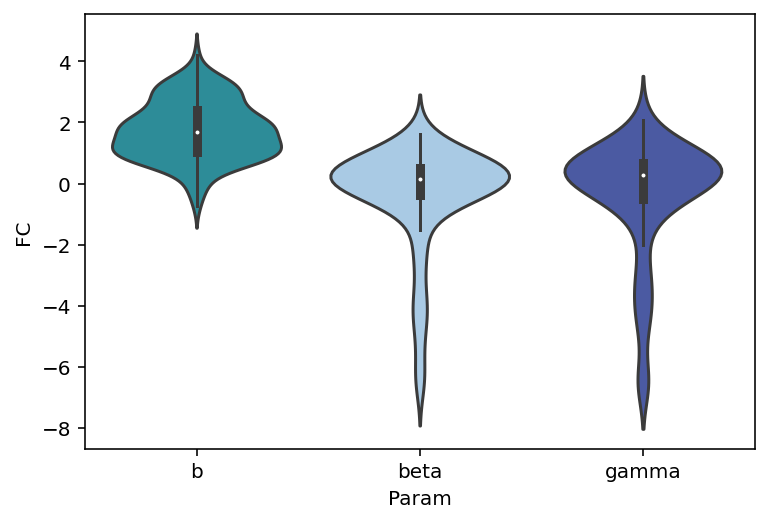

In [156]:
palette={'b':col_b[0],'beta':col_beta[0],'gamma':col_gamma[0],'expr':col_expr[0]}
sns.violinplot(data=fc_res, x="Param", y="FC",palette=palette)

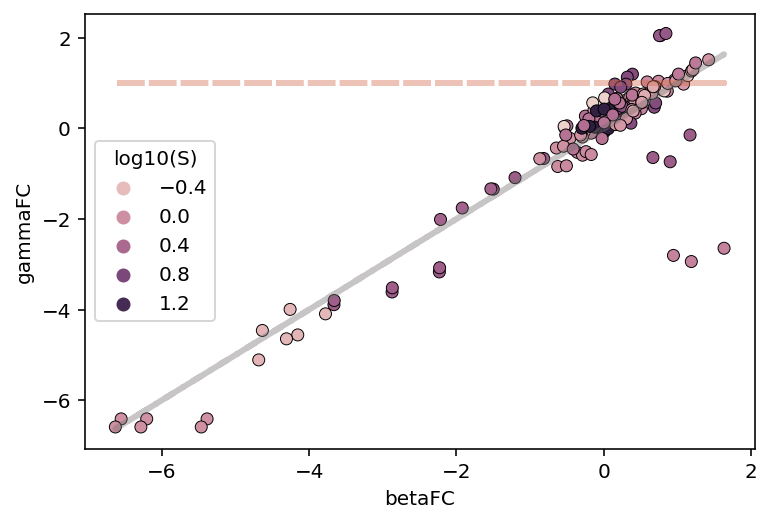

In [159]:
freq = pd.DataFrame()
freq['betaFC'] = list(fc_res['FC'][fc_res['Param'].isin(['beta'])])
freq['gammaFC'] = list(fc_res['FC'][fc_res['Param'].isin(['gamma'])])
freq['log10(S)'] = list(np.log10(fc_res['meanS'][fc_res['Param'].isin(['gamma'])]))


sns.scatterplot(data=freq,x='betaFC', y='gammaFC',hue='log10(S)',edgecolor='black')


plt.plot(freq['betaFC'],[1]*len(freq['betaFC']),'--',color=col_red,linewidth=3,alpha=0.4)
plt.plot(list(freq['betaFC']),list(freq['betaFC']),'--',color=col_gray,linewidth=3,alpha=0.4)

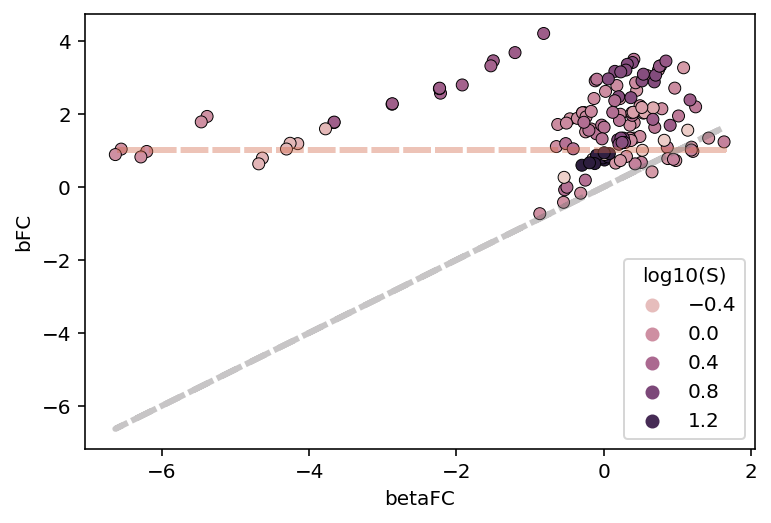

In [162]:
freq = pd.DataFrame()
freq['betaFC'] = list(fc_res['FC'][fc_res['Param'].isin(['beta'])])
freq['bFC'] = list(fc_res['FC'][fc_res['Param'].isin(['b'])])
freq['log10(S)'] = list(np.log10(fc_res['meanS'][fc_res['Param'].isin(['b'])]))

sns.scatterplot(data=freq,x='betaFC', y='bFC',hue='log10(S)',edgecolor='black')


plt.plot(freq['betaFC'],[1]*len(freq['betaFC']),'--',color=col_red,linewidth=3,alpha=0.4)
plt.plot(list(freq['betaFC']),list(freq['betaFC']),'--',color=col_gray,linewidth=3,alpha=0.4)

**Analyze Examples of Known Relationships**

In [63]:
#'ARRDC3' downregulates 'ITGB4'
#SNAI1 repressed CDH1 (Cadherin),NANOG, NR5A2, KIT -> https://stemcellsjournals.onlinelibrary.wiley.com/doi/full/10.1002/stem.1898
# Apoptosis--> global mRNA decay ,
#CBL targets -->EGFR, FLT3, KIT, MPL https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4775400/
#ubash3b (also + CBL) targets --> 
#ETS/FEV trans factors
#KMT2A methylation 
#MIDN degrades FOSB, EGR1, NR4A1, IRF4, NEUROD1, PAX8, GATA1 https://www.science.org/doi/10.1126/science.adh5021
#RUNX1T1 --> PTK2B, RBFOX2 alt splicing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7822815/